<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/nn_from_scratchV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
from jax import value_and_grad
from jax import jit

In [ ]:
jax.device_count()

1

In [ ]:
jax.devices()

In [ ]:
#from jax import random
#key = random.PRNGKey(0)
from numpy import random

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
#dir(jnp.zeros(5).device())

In [ ]:
jnp.zeros(5).device().device_kind

'cpu'

In [ ]:
#@title
# from https://github.com/google/jax/blob/main/examples/datasets.py

import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np


_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / np.float32(255.)
  test_images = _partial_flatten(test_images) / np.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if permute_train:
    perm = np.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return {'train_img': train_images, 'train_lab': train_labels, 'test_img': test_images, 'test_lab': test_labels}

In [ ]:
mnist_dat = mnist()

downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz to /tmp/jax_example_data/


In [ ]:
mnist_dat['train_img'][0].shape

(784,)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def show_img(img):
  plt.imshow(img.reshape(28,28))

7


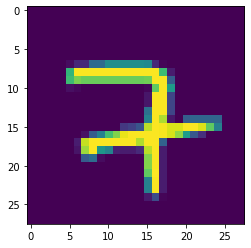

In [ ]:
demo_idx = 38
demo_img = mnist_dat['train_img'][demo_idx]
show_img(demo_img)
print(jnp.argmax(mnist_dat['train_lab'][demo_idx]))

In [ ]:
#jnp.argmax(model_init_predict(demo_img))

In [ ]:
def model_random_predict(img):
  return int(random.random()*10)

In [ ]:
model_random_predict('test')

9

In [ ]:
def evaluate(pred_func, max=2000, progress_func=lambda x: x):
  correct = 0
  incorrect = 0
  count = 0

  for train_img, train_lab in progress_func(zip(mnist_dat['test_img'][:max], mnist_dat['test_lab'][:max])):
    pred = pred_func(train_img)
    if jnp.argmax(pred) == jnp.argmax(train_lab):
      correct += 1
    else:
      incorrect += 1
    count += 1
    final_stats = {'correct': correct, 'total': count, 'accuracy': correct/count}
    #tqdm.write(str(final_stats))

  return final_stats

In [ ]:
evaluate(model_random_predict)

{'accuracy': 0.0875, 'correct': 175, 'total': 2000}

In [ ]:
class NNModel:

  def __init__(self, input_size, hidden_size, out_size, ce_loss=False, use_mom=False):

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.out_size = out_size

    self.cross_entropy_loss = ce_loss
    self.momentum = use_mom

    # use normed initialization?
    self.weights_l1 = jnp.array(random.normal(size=(input_size, hidden_size))) / jnp.sqrt(hidden_size)
    self.w1_m = jnp.zeros_like(self.weights_l1)
    self.weights_l2 = jnp.array(random.normal(size=(hidden_size, out_size))) / jnp.sqrt(out_size)
    self.w2_m = jnp.zeros_like(self.weights_l2)
    self.bias_l1 = jnp.array(random.normal(size=(hidden_size,)))
    self.b1_m = jnp.zeros_like(self.bias_l1)
    self.bias_l2 = jnp.array(random.normal(size=(out_size,)))
    self.b2_m = jnp.zeros_like(self.bias_l2)

    @jit
    def forward_single(weights_l1, weights_l2, bias_l1, bias_l2, img):
      # matrix mult, bias, relu activation
      hidden = jnp.maximum(img @ weights_l1 + bias_l1, 0.0)
      out_raw = hidden @ weights_l2 + bias_l2
      # softmax to probability distribution
      out_exp = jnp.e ** out_raw
      out_probs = out_exp / out_exp.sum()
      return out_probs

    @jit
    def loss(w1, w2, b1, b2, img, lab):
      preds = forward_single(w1, w2, b1, b2, img)
      #print(preds)
      #print(lab)
      if self.cross_entropy_loss:
        idx = jnp.argmax(lab)
        return -jnp.log(preds[idx])
      else:
        diffs = (preds-lab) ** 2
        return diffs.mean()

    self.grad_f = value_and_grad(loss, argnums=[0,1,2,3])
    self.forward_single = lambda img: forward_single(
        self.weights_l1, self.weights_l2, 
        self.bias_l1, self.bias_l2, img)

  def grad_func(self, img, lab): 
    return self.grad_f(
        self.weights_l1, 
        self.weights_l2, 
        self.bias_l1, 
        self.bias_l2, 
        img, lab)

  def forward_batched(self, imgs):
    #hidden = jnp.maximum(imgs @ self.weights_l1 + self.bias_l1, 0.0)
    #out_raw = 
    pass

  def update(self, img, lab, lr_a, lr_b):
    loss, grads = self.grad_func(img, lab)
    w1_d, w2_d, b1_d, b2_d = grads
    if self.momentum:
      # update momentum
      self.w1_m = lr_b * self.w1_m + w1_d * (1-lr_b)
      self.w2_m = lr_b * self.w2_m + w2_d * (1-lr_b)
      self.b1_m = lr_b * self.b1_m + b1_d * (1-lr_b)
      self.b2_m = lr_b * self.b2_m + b2_d * (1-lr_b)
      # update parameters
      self.weights_l1 -= self.w1_m * lr_a
      self.weights_l2 -= self.w2_m * lr_a
      self.bias_l1 -= self.b1_m * lr_a
      self.bias_l2 -= self.b2_m * lr_a
    else:
      # update parameters
      self.weights_l1 -= w1_d * lr_a #self.w1_m * lr_b
      self.weights_l2 -= w2_d * lr_a #self.w2_m * lr_b
      self.bias_l1 -= b1_d * lr_a #self.b1_m * lr_b
      self.bias_l2 -= b2_d * lr_a #self.b2_m * lr_b
    return loss


In [ ]:
def create_fresh_mnist_model(hidden_size=256, use_momentum=False, use_ce_loss=False):
  return NNModel(
      mnist_dat['train_img'][0].shape[0], hidden_size, mnist_dat['train_lab'][0].shape[0],
      ce_loss=use_ce_loss, use_mom=use_momentum)

In [ ]:
model = create_fresh_mnist_model()

In [ ]:
loss, grd = model.grad_func(mnist_dat['train_img'][demo_idx], mnist_dat['train_lab'][demo_idx])

In [ ]:
for x in grd:
  print(x.shape)

(784, 256)
(256, 10)
(256,)
(10,)


In [ ]:
len(mnist_dat['train_img'])

60000

In [ ]:
def test_train_performance(train_its, test_interval, test_its, hidden_size=256, use_momentum=False, use_ce_loss=False, alpha=0.005, beta=0.9):
  mod = create_fresh_mnist_model(hidden_size=hidden_size, use_momentum=use_momentum, use_ce_loss=use_ce_loss)
  accs = []
  for i in tqdm(range(train_its)):
    loss = mod.update(mnist_dat['train_img'][i], mnist_dat['train_lab'][i], alpha, beta)
    if i % test_interval == 0:
      accs.append(evaluate(mod.forward_single, max=test_its))
  return {
      'stats': accs, 
      'train_its': train_its, 'test_interval': test_interval, 
      'test_its': test_its, 'hidden_size': hidden_size, 
      'use_momentum': use_momentum, 'use_ce_loss': use_ce_loss, 
      'alpha': alpha, 'beta': beta }

In [ ]:
experiments = {}

In [ ]:

#experiments['lr_0.005'] = test_train_performance(5000, 500, 200, alpha=0.005)
#experiments['lr_0.015'] = test_train_performance(5000, 500, 200, alpha=0.015)
experiments['lr_0.05'] = test_train_performance(15000, 500, 200, alpha=0.05)
#experiments['lr_0.1'] = test_train_performance(5000, 500, 200, alpha=0.1)
experiments['lr_0.05_momentum'] = test_train_performance(15000, 500, 200, use_momentum=True, alpha=0.05, beta=0.9)

In [ ]:
experiments['lr_0.05_ce_loss'] = test_train_performance(15000, 500, 200, use_ce_loss=True, alpha=0.05)
experiments['lr_0.05_ce_loss_momentum'] = test_train_performance(15000, 500, 200, use_ce_loss=True, use_momentum=True, alpha=0.05, beta=0.9)



In [ ]:
experiments['lr_0.005_ce_loss_momentum'] = test_train_performance(15000, 500, 200, use_ce_loss=True, use_momentum=True, alpha=0.005, beta=0.9)


In [ ]:
experiments['lr_0.002_ce_loss_momentum'] = test_train_performance(15000, 500, 200, use_ce_loss=True, use_momentum=True, alpha=0.002, beta=0.9)
experiments['lr_0.002_momentum'] = test_train_performance(15000, 500, 200, use_momentum=True, alpha=0.002, beta=0.9)


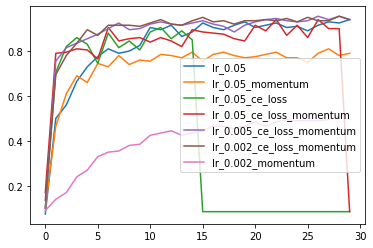

In [ ]:
for name, data in experiments.items():
  nums = [s['accuracy'] for s in data['stats']]
  plt.plot(list(range(len(nums))), nums, label=name)
plt.legend()

In [ ]:
experiments

{'lr_0.002_ce_loss_momentum': {'alpha': 0.002,
  'beta': 0.9,
  'hidden_size': 256,
  'stats': [{'accuracy': 0.135, 'correct': 27, 'total': 200},
   {'accuracy': 0.695, 'correct': 139, 'total': 200},
   {'accuracy': 0.78, 'correct': 156, 'total': 200},
   {'accuracy': 0.835, 'correct': 167, 'total': 200},
   {'accuracy': 0.895, 'correct': 179, 'total': 200},
   {'accuracy': 0.87, 'correct': 174, 'total': 200},
   {'accuracy': 0.915, 'correct': 183, 'total': 200},
   {'accuracy': 0.915, 'correct': 183, 'total': 200},
   {'accuracy': 0.915, 'correct': 183, 'total': 200},
   {'accuracy': 0.91, 'correct': 182, 'total': 200},
   {'accuracy': 0.925, 'correct': 185, 'total': 200},
   {'accuracy': 0.94, 'correct': 188, 'total': 200},
   {'accuracy': 0.92, 'correct': 184, 'total': 200},
   {'accuracy': 0.915, 'correct': 183, 'total': 200},
   {'accuracy': 0.935, 'correct': 187, 'total': 200},
   {'accuracy': 0.95, 'correct': 190, 'total': 200},
   {'accuracy': 0.93, 'correct': 186, 'total': 200